# 🧪 TEST CELL - Run This First!

**Click the ▶️ button above this cell or press Shift+Enter to test if output works!**


In [1]:
# ═══════════════════════════════════════════════════════════
# 🧪 SUPER SIMPLE TEST - Run this cell!
# ═══════════════════════════════════════════════════════════
# Click the ▶️ button above OR press Shift+Enter
# Then look DIRECTLY BELOW this cell for output!

import sys
print("=" * 70)
print("HELLO! IF YOU SEE THIS TEXT BELOW, IT'S WORKING!")
print("=" * 70)
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")
print("=" * 70)
print("✅ OUTPUT IS WORKING!")
print("=" * 70)
print("\nIf you see this, your notebook output is working in Cursor!")
sys.stdout.flush()  # Force output to appear


HELLO! IF YOU SEE THIS TEXT BELOW, IT'S WORKING!
Python version: 3.13.0 (v3.13.0:60403a5409f, Oct  7 2024, 00:37:40) [Clang 15.0.0 (clang-1500.3.9.4)]
Python executable: /Users/user/Documents/Quant-Finance-Project1/.venv/bin/python
✅ OUTPUT IS WORKING!

If you see this, your notebook output is working in Cursor!


# Monte Carlo Pricing for American Call Options with Dividends

This notebook implements **Monte Carlo pricing for American-style call options** using:
- **Geometric Brownian Motion (GBM) with dividends**
- **Longstaff-Schwartz Monte Carlo (LSMC)** for early exercise
- **Black-Scholes-Merton (BSM)** for European approximation
- **Implied Volatility Smile** from real US option chain data

We'll use real AAPL data and build up progressively from data fetching to final pricing and visualization.


## 1. Fetch US Market Data


In [ ]:
import numpy as np
import matplotlib
matplotlib.use('inline')  # Force inline backend for Cursor/VS Code
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter/Cursor
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # High quality plots

# Set style
plt.style.use('dark_background')
plt.ion()  # Turn on interactive mode
np.random.seed(42)

print("✅ Matplotlib configured for inline display in Cursor")

print("Fetching AAPL market data...")
ticker = yf.Ticker('AAPL')
info = ticker.info

# Get current price
S0 = ticker.history(period='1d')['Close'].iloc[-1]
print(f"Current Stock Price (S0): ${S0:.2f}")

# Get historical volatility (252 trading days)
hist = ticker.history(period='1y')
returns = hist['Close'].pct_change().dropna()
sigma = returns.std() * np.sqrt(252)  # Annualized
print(f"Historical Volatility (σ): {sigma:.4f} ({sigma*100:.2f}%)")

# Get dividend yield
q = info.get('dividendYield', 0.0) or 0.0
if q == 0:
    # Try to calculate from recent dividends
    divs = ticker.dividends
    if len(divs) > 0:
        annual_div = divs.tail(4).sum() if len(divs) >= 4 else divs.sum()
        q = annual_div / S0
print(f"Dividend Yield (q): {q:.4f} ({q*100:.2f}%)")

# Risk-free rate (hardcoded) #TODO ???
r = 0.05
print(f"Risk-free Rate (r): {r:.4f} ({r*100:.2f}%)")

# Option parameters
K = round(S0)  # At-the-money strike
T = 1.0  # 1 year to expiration
steps = 252  # Daily steps
dt = T / steps

print(f"\nOption Parameters:")
print(f"Strike (K): ${K:.2f}")
print(f"Time to Expiration (T): {T:.2f} years")
print(f"Number of Steps: {steps}")
print(f"Time Step (dt): {dt:.6f} years")


✅ Matplotlib configured for inline display in Cursor
Fetching AAPL market data...
Current Stock Price (S0): $272.41
Historical Volatility (σ): 0.3263 (32.63%)
Dividend Yield (q): 0.3800 (38.00%)
Risk-free Rate (r): 0.0500 (5.00%)

Option Parameters:
Strike (K): $272.00
Time to Expiration (T): 1.00 years
Number of Steps: 252
Time Step (dt): 0.003968 years


## 2. Simulate GBM Paths with Dividends


In [3]:
def gbm_paths_div(S0, r, q, sigma, T, steps, N_paths):
    """
    Generate GBM paths with dividends using exact solution.
    
    dS = (r - q) S dt + sigma S dW
    
    Exact solution: S_t = S_{t-1} * exp((r - q - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z)
    
    Returns: (steps+1) x N_paths array of stock prices
    """
    dt = T / steps
    # Pre-allocate array
    paths = np.zeros((steps + 1, N_paths))
    paths[0, :] = S0
    
    # Drift and diffusion coefficients
    drift = (r - q - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    # Generate random shocks
    Z = np.random.normal(0, 1, size=(steps, N_paths))
    
    # Vectorized path generation
    for t in range(1, steps + 1):
        paths[t, :] = paths[t-1, :] * np.exp(drift + diffusion * Z[t-1, :])
    
    return paths

# Test with small number of paths
N_test = 100
test_paths = gbm_paths_div(S0, r, q, sigma, T, steps, N_test)
print(f"Generated {N_test} GBM paths with dividends")
print(f"Path shape: {test_paths.shape}")
print(f"Final prices range: ${test_paths[-1, :].min():.2f} - ${test_paths[-1, :].max():.2f}")


Generated 100 GBM paths with dividends
Path shape: (253, 100)
Final prices range: $81.66 - $431.51


## 3. Black-Scholes-Merton European Call with Dividends


In [4]:
def bsm_call_div(S0, K, r, q, sigma, T):
    """
    Black-Scholes-Merton European call option price with dividends.
    
    C = S0 * exp(-q*T) * N(d1) - K * exp(-r*T) * N(d2)
    where:
    d1 = (ln(S0/K) + (r - q + 0.5*sigma^2)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    """
    if sigma <= 0 or T <= 0:
        return max(S0 * np.exp(-q*T) - K * np.exp(-r*T), 0)
    
    sqrt_T = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    price = S0 * np.exp(-q * T) * N_d1 - K * np.exp(-r * T) * N_d2
    return max(price, 0)

# Calculate BSM price
bsm_price = bsm_call_div(S0, K, r, q, sigma, T)
print(f"BSM European Call Price: ${bsm_price:.4f}")


BSM European Call Price: $5.8437


## 4. Longstaff-Schwartz Monte Carlo for American Call


In [5]:
def lsmc_american_call(S0, K, r, q, sigma, T, steps, N_paths, basis_degree=3):
    """
    Longstaff-Schwartz Monte Carlo for American call option.
    
    Uses Laguerre polynomials as basis functions for continuation value regression.
    """
    dt = T / steps
    discount_factor = np.exp(-r * dt)
    
    # Generate paths
    paths = gbm_paths_div(S0, r, q, sigma, T, steps, N_paths)
    
    # Initialize cash flows (discounted payoffs at expiration)
    cash_flows = np.maximum(paths[-1, :] - K, 0)
    
    # Work backwards from expiration
    for t in range(steps - 1, 0, -1):
        # In-the-money paths at time t
        itm_mask = paths[t, :] > K
        
        if np.sum(itm_mask) == 0:
            # No ITM paths, continue
            cash_flows *= discount_factor
            continue
        
        # Current stock prices for ITM paths
        S_t = paths[t, itm_mask]
        
        # Continuation values (discounted future cash flows)
        continuation = cash_flows[itm_mask] * discount_factor
        
        # Immediate exercise value
        exercise = S_t - K
        
        # Build basis functions (Laguerre polynomials)
        # Normalize stock price for numerical stability
        x = S_t / K  # Normalized stock price
        
        # Laguerre polynomials L_0, L_1, L_2, L_3
        basis = np.zeros((len(S_t), basis_degree + 1))
        basis[:, 0] = 1.0  # L_0(x) = 1
        basis[:, 1] = 1.0 - x  # L_1(x) = 1 - x
        if basis_degree >= 2:
            basis[:, 2] = 0.5 * (2 - 4*x + x**2)  # L_2(x) = 0.5*(2 - 4x + x^2)
        if basis_degree >= 3:
            basis[:, 3] = (1/6) * (6 - 18*x + 9*x**2 - x**3)  # L_3(x)
        
        # Regression: continuation = beta * basis
        # Use least squares
        try:
            beta = np.linalg.lstsq(basis, continuation, rcond=None)[0]
            estimated_continuation = basis @ beta
        except:
            # Fallback: use mean continuation value
            estimated_continuation = np.mean(continuation) * np.ones_like(continuation)
        
        # Exercise decision: exercise if immediate > estimated continuation
        exercise_mask = exercise > estimated_continuation
        
        # Update cash flows: exercise now or continue
        cash_flows[itm_mask] = np.where(exercise_mask, exercise, continuation)
        
        # Discount all cash flows
        cash_flows *= discount_factor
    
    # Final discount from t=1 to t=0
    cash_flows *= discount_factor
    
    # Option price is expected discounted payoff
    price = np.mean(cash_flows)
    std_err = np.std(cash_flows) / np.sqrt(N_paths)
    
    return price, std_err, cash_flows

print("LSMC American Call function defined.")
print("Note: For American calls with dividends, early exercise may be optimal.")


LSMC American Call function defined.
Note: For American calls with dividends, early exercise may be optimal.


## 5. Convergence Analysis


In [6]:
# Convergence analysis: different numbers of paths
# Using smaller max to avoid long waits - can increase later if needed
N_paths_list = [10, 50, 100, 500, 1000, 5000, 10000, 25000]  # Reduced from 100k for faster execution
mc_prices = []
mc_stds = []

print("Running convergence analysis...")
print("(This may take a few minutes - be patient!)")
for i, N in enumerate(N_paths_list):
    print(f"Processing {i+1}/{len(N_paths_list)}: N={N}...", end=" ", flush=True)
    price, std_err, _ = lsmc_american_call(S0, K, r, q, sigma, T, steps, N)
    mc_prices.append(price)
    mc_stds.append(std_err)
    print(f"Done: MC Price = ${price:.4f} ± ${1.96*std_err:.4f} (95% CI)")

mc_prices = np.array(mc_prices)
mc_stds = np.array(mc_stds)

# Final price with highest N
final_mc_price = mc_prices[-1]
final_mc_std = mc_stds[-1]
print(f"\n✅ Final MC American Call Price: ${final_mc_price:.4f} ± ${1.96*final_mc_std:.4f} (95% CI)")
print(f"   (Based on {N_paths_list[-1]:,} paths)")


Running convergence analysis...
(This may take a few minutes - be patient!)
Processing 1/8: N=10... Done: MC Price = $49.4797 ± $32.8123 (95% CI)
Processing 2/8: N=50... Done: MC Price = $18.9572 ± $7.1184 (95% CI)
Processing 3/8: N=100... Done: MC Price = $18.9506 ± $6.9315 (95% CI)
Processing 4/8: N=500... Done: MC Price = $14.9961 ± $2.4505 (95% CI)
Processing 5/8: N=1000... Done: MC Price = $13.9072 ± $1.3202 (95% CI)
Processing 6/8: N=5000... Done: MC Price = $13.7012 ± $0.5328 (95% CI)
Processing 7/8: N=10000... Done: MC Price = $13.9591 ± $0.3716 (95% CI)
Processing 8/8: N=25000... Done: MC Price = $13.6112 ± $0.2391 (95% CI)

✅ Final MC American Call Price: $13.6112 ± $0.2391 (95% CI)
   (Based on 25,000 paths)


## 6. Implied Volatility Modeling


In [7]:
def implied_vol(market_price, S0, K, r, q, T, tol=1e-6, max_iter=100):
    """
    Calculate implied volatility using bisection method.
    """
    if market_price <= 0:
        return 0.0
    
    # Bounds for bisection
    vol_low = 0.001
    vol_high = 5.0
    
    # Check bounds
    price_low = bsm_call_div(S0, K, r, q, vol_low, T)
    price_high = bsm_call_div(S0, K, r, q, vol_high, T)
    
    if market_price < price_low:
        return vol_low
    if market_price > price_high:
        return vol_high
    
    # Bisection
    for _ in range(max_iter):
        vol_mid = (vol_low + vol_high) / 2
        price_mid = bsm_call_div(S0, K, r, q, vol_mid, T)
        
        if abs(price_mid - market_price) < tol:
            return vol_mid
        
        if price_mid < market_price:
            vol_low = vol_mid
        else:
            vol_high = vol_mid
    
    return (vol_low + vol_high) / 2

# Fetch option chain data
print("Fetching AAPL option chain...")
try:
    # Get expiration dates
    expirations = ticker.options
    if len(expirations) > 0:
        # Find expiration closest to 1 year
        target_date = datetime.now() + timedelta(days=365)
        exp_dates = [datetime.strptime(exp, '%Y-%m-%d') for exp in expirations]
        closest_exp = min(exp_dates, key=lambda x: abs((x - target_date).days))
        exp_str = closest_exp.strftime('%Y-%m-%d')
        
        # Get option chain
        chain = ticker.option_chain(exp_str)
        calls = chain.calls
        
        # Calculate time to expiration
        T_chain = (closest_exp - datetime.now()).days / 365.0
        
        print(f"Using expiration: {exp_str} (T = {T_chain:.3f} years)")
        print(f"Found {len(calls)} call options")
        
        # Filter reasonable strikes and prices
        valid_calls = calls[(calls['lastPrice'] > 0) & (calls['strike'] > 0) & 
                           (calls['strike'] > S0 * 0.5) & (calls['strike'] < S0 * 2.0)]
        
        if len(valid_calls) > 0:
            strikes_chain = valid_calls['strike'].values
            prices_chain = valid_calls['lastPrice'].values
            
            # Calculate IV for each
            ivs = []
            valid_strikes = []
            for i in range(len(strikes_chain)):
                try:
                    iv = implied_vol(prices_chain[i], S0, strikes_chain[i], r, q, T_chain)
                    if 0.01 < iv < 2.0:  # Reasonable IV range
                        ivs.append(iv)
                        valid_strikes.append(strikes_chain[i])
                except:
                    continue
            
            ivs = np.array(ivs)
            valid_strikes = np.array(valid_strikes)
            
            if len(ivs) > 0:
                print(f"\nCalculated {len(ivs)} implied volatilities")
                print(f"IV Range: {ivs.min():.4f} - {ivs.max():.4f}")
                
                # Find ATM IV
                atm_idx = np.argmin(np.abs(valid_strikes - S0))
                atm_iv = ivs[atm_idx]
                print(f"ATM IV (K={valid_strikes[atm_idx]:.2f}): {atm_iv:.4f}")
            else:
                print("No valid IVs calculated. Using hypothetical data.")
                ivs = None
                valid_strikes = None
        else:
            print("No valid call options found. Using hypothetical data.")
            ivs = None
            valid_strikes = None
    else:
        print("No expiration dates available. Using hypothetical data.")
        ivs = None
        valid_strikes = None
        
except Exception as e:
    print(f"Error fetching option chain: {e}")
    print("Using hypothetical IV smile data.")
    ivs = None
    valid_strikes = None

# If no real data, create hypothetical IV smile
if ivs is None or len(ivs) == 0:
    print("\nGenerating hypothetical IV smile...")
    # Create a realistic IV smile (higher for OTM and ITM)
    k_range = np.linspace(S0 * 0.7, S0 * 1.3, 20)
    # Smile shape: higher IV for OTM and ITM
    moneyness = k_range / S0
    ivs = sigma * (1 + 0.3 * (moneyness - 1)**2 + 0.1 * np.random.normal(0, 0.05, len(k_range)))
    valid_strikes = k_range
    print(f"Generated hypothetical IV smile with {len(ivs)} points")


Fetching AAPL option chain...
Using expiration: 2026-12-18 (T = 1.088 years)
Found 70 call options

Calculated 45 implied volatilities
IV Range: 0.4389 - 1.9639
ATM IV (K=270.00): 0.8056


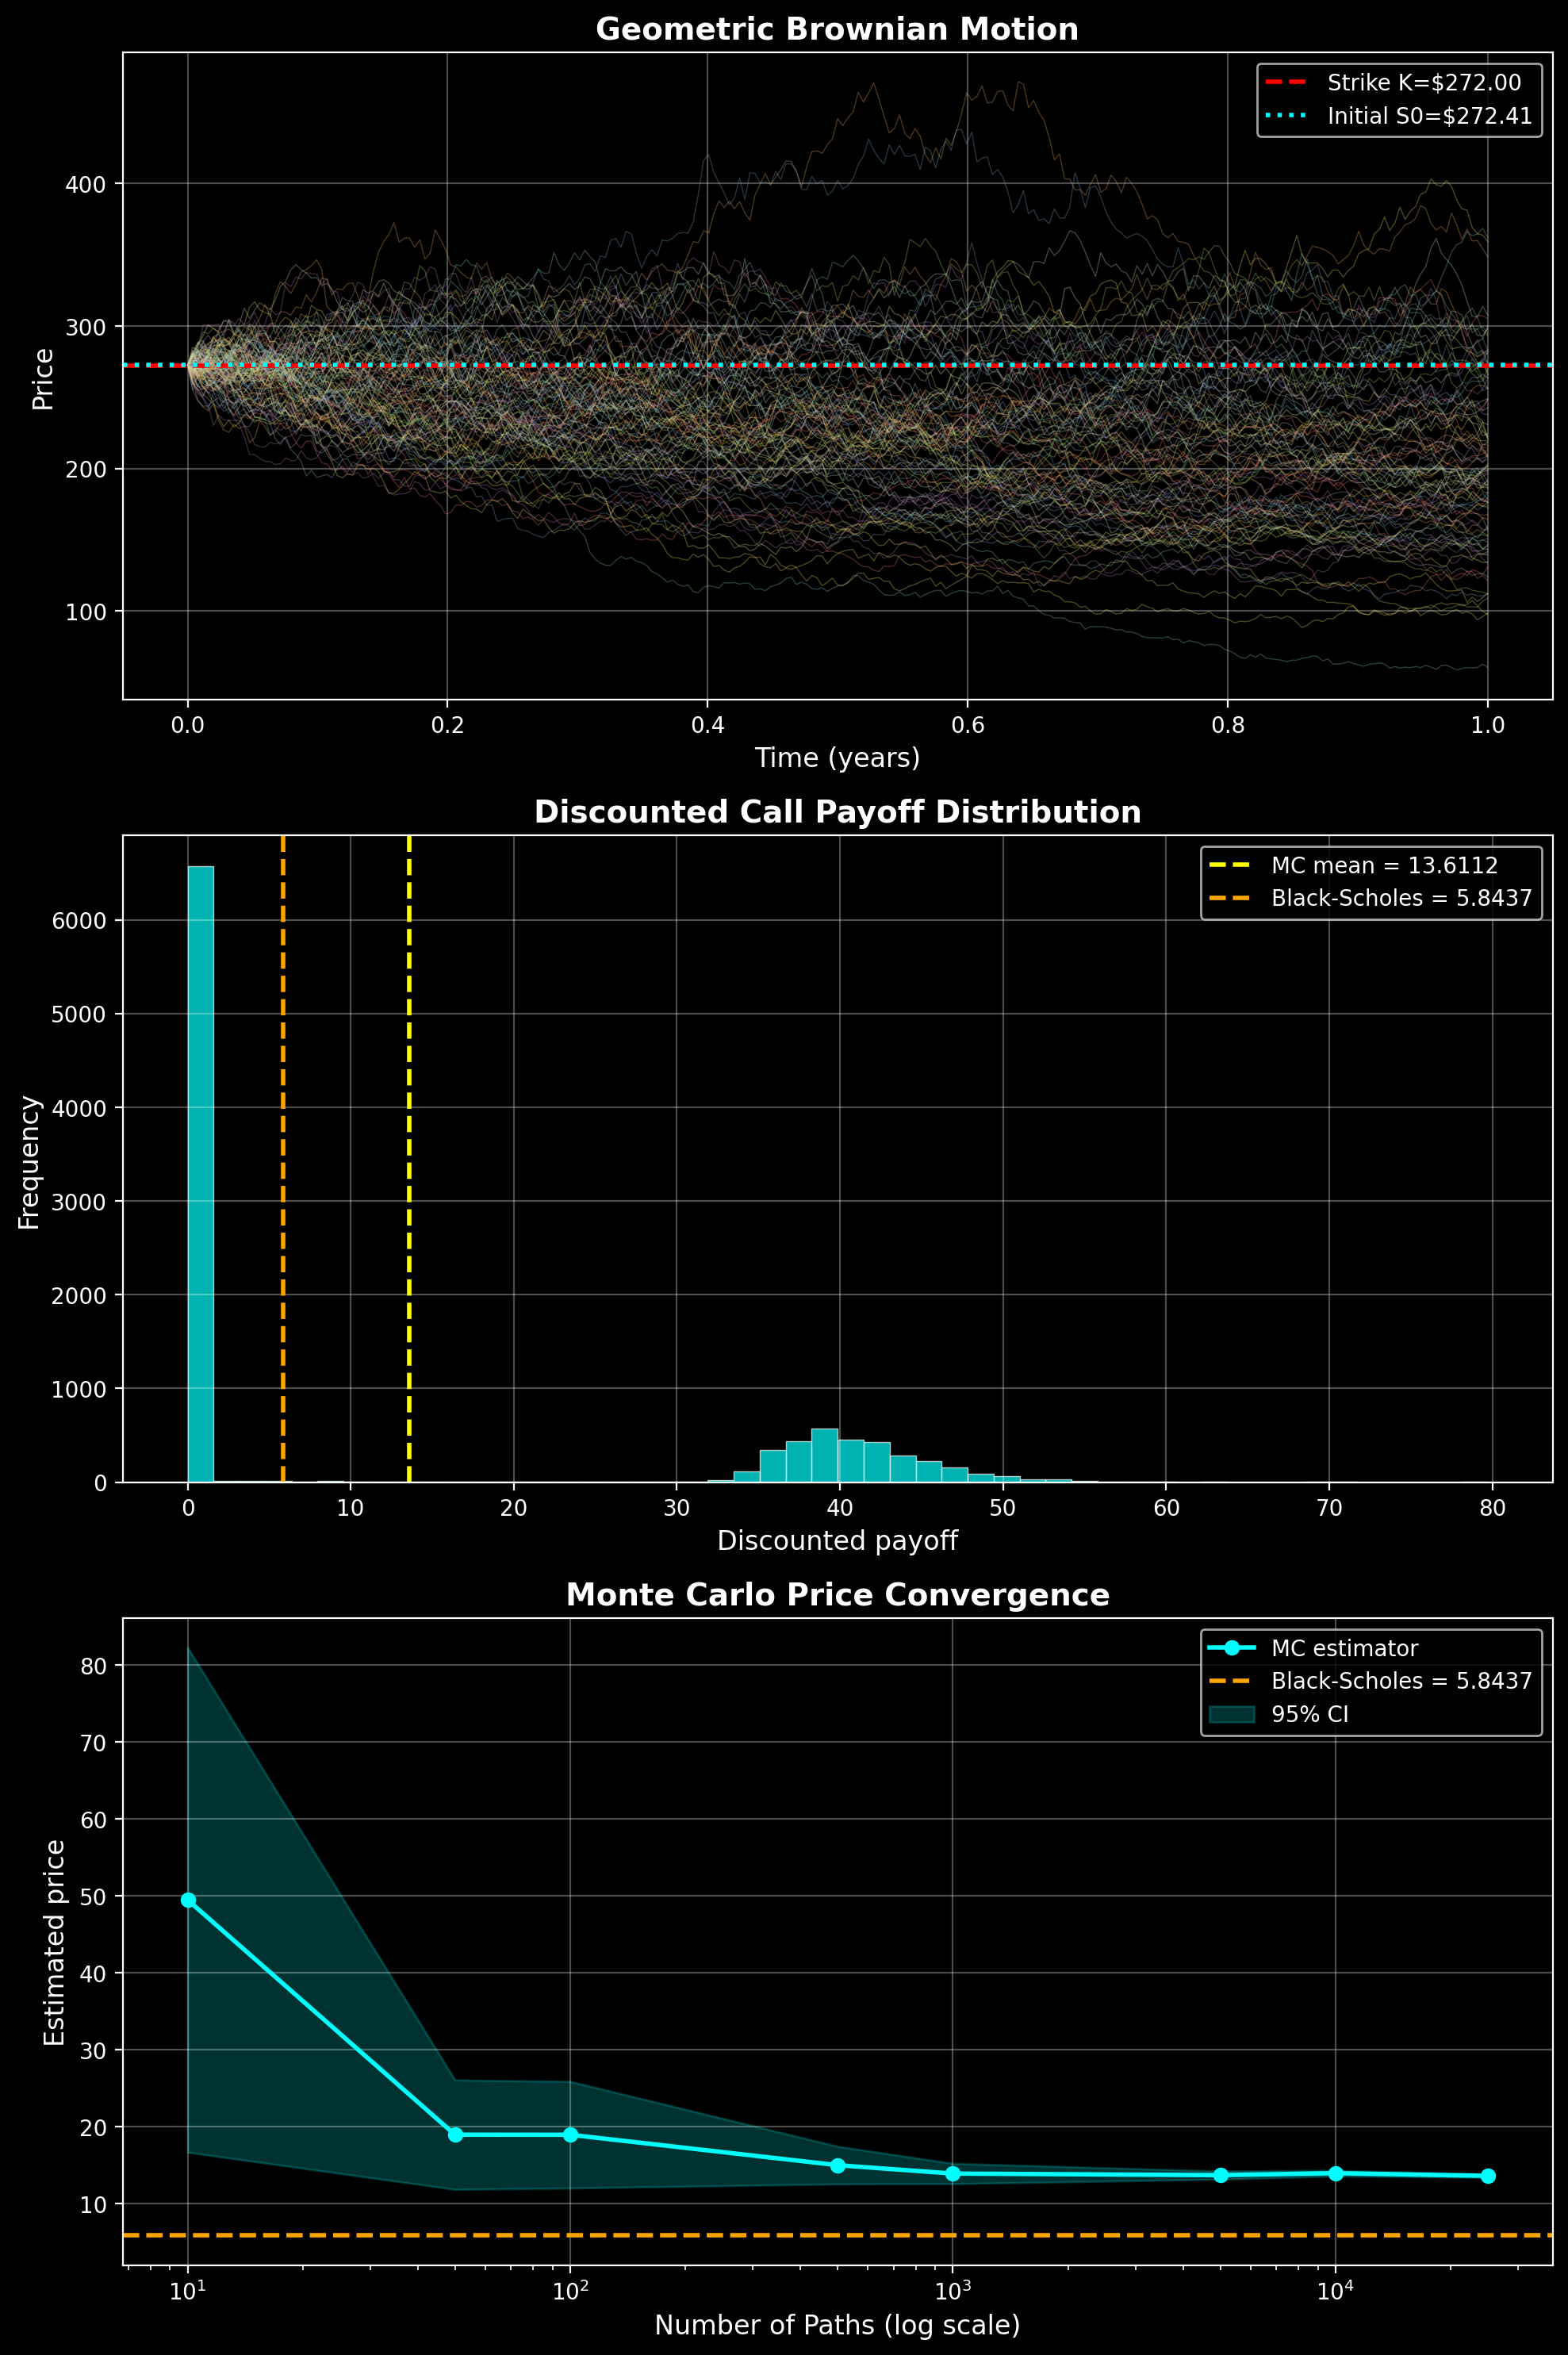

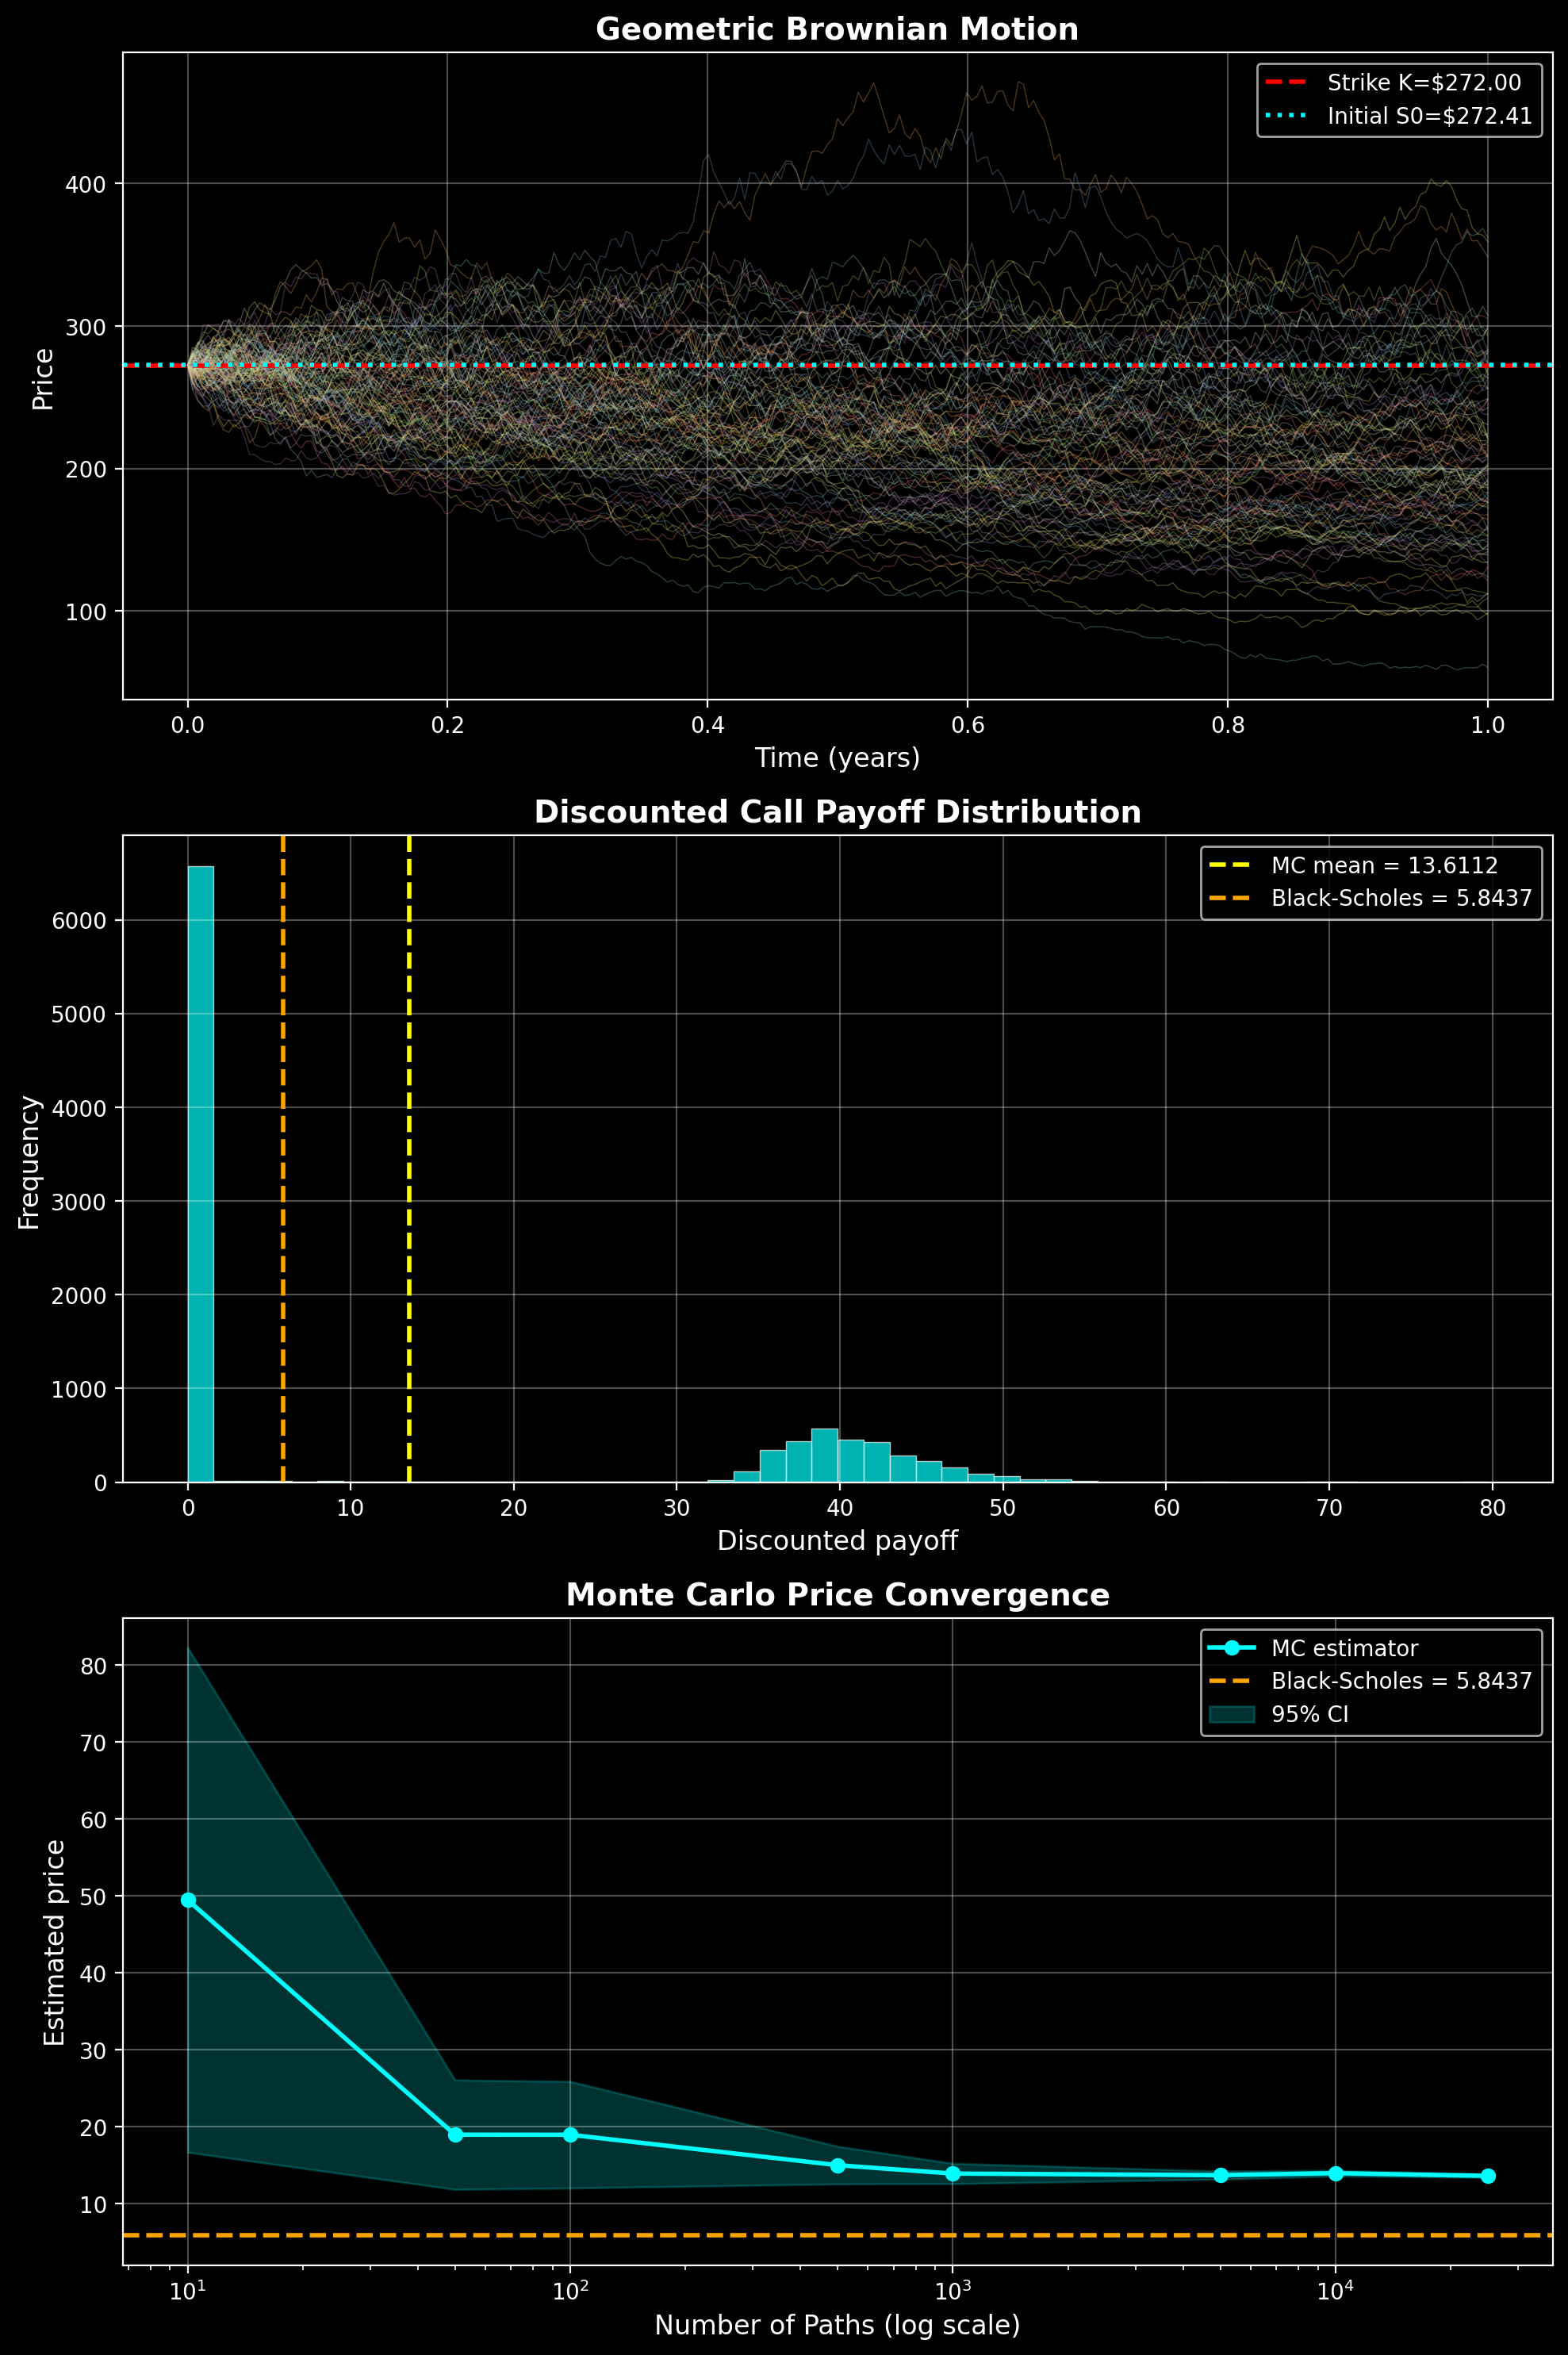


✅ Visualizations displayed:
   - Top: 100 GBM paths
   - Middle: Payoff distribution histogram
   - Bottom: MC convergence analysis


<Figure size 640x480 with 0 Axes>

In [8]:
# Generate paths for visualization
N_viz = 100
paths_viz = gbm_paths_div(S0, r, q, sigma, T, steps, N_viz)

# Get payoffs for histogram (using final MC run)
_, _, payoffs = lsmc_american_call(S0, K, r, q, sigma, T, steps, 10000)

# PLOTS STACKED VERTICALLY 
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# 1. GBM Paths (Top Plot)
time_axis = np.linspace(0, T, steps + 1)
for i in range(N_viz):
    axs[0].plot(time_axis, paths_viz[:, i], alpha=0.3, linewidth=0.5)
axs[0].axhline(y=K, color='r', linestyle='--', linewidth=2, label=f'Strike K=${K:.2f}')
axs[0].axhline(y=S0, color='cyan', linestyle=':', linewidth=2, label=f'Initial S0=${S0:.2f}')
axs[0].set_title('Geometric Brownian Motion', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Time (years)', fontsize=12)
axs[0].set_ylabel('Price', fontsize=12)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# 2. Payoff Histogram (Middle Plot)
axs[1].hist(payoffs, bins=50, alpha=0.7, color='cyan', edgecolor='white', linewidth=0.5)
axs[1].axvline(x=final_mc_price, color='yellow', linestyle='--', linewidth=2, 
               label=f'MC mean = {final_mc_price:.4f}')
axs[1].axvline(x=bsm_price, color='orange', linestyle='--', linewidth=2, 
               label=f'Black-Scholes = {bsm_price:.4f}')
axs[1].set_title('Discounted Call Payoff Distribution', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Discounted payoff', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# 3. Convergence Plot (Bottom Plot)
axs[2].semilogx(N_paths_list, mc_prices, 'o-', color='cyan', linewidth=2, markersize=6, 
                label='MC estimator')
axs[2].axhline(y=bsm_price, color='orange', linestyle='--', linewidth=2, 
               label=f'Black-Scholes = {bsm_price:.4f}')
# Add confidence intervals
axs[2].fill_between(N_paths_list, mc_prices - 1.96*mc_stds, mc_prices + 1.96*mc_stds, 
                    alpha=0.2, color='cyan', label='95% CI')
axs[2].set_title('Monte Carlo Price Convergence', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Number of Paths (log scale)', fontsize=12)
axs[2].set_ylabel('Estimated price', fontsize=12)
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show(block=False)
plt.draw()

# Force display in Cursor/VS Code
try:
    from IPython.display import display, HTML
    display(fig)
except:
    pass

print(f"\n✅ Visualizations displayed:")
print(f"   - Top: {N_viz} GBM paths")
print(f"   - Middle: Payoff distribution histogram")
print(f"   - Bottom: MC convergence analysis")


## 7b. Implied Volatility Smile (Optional)


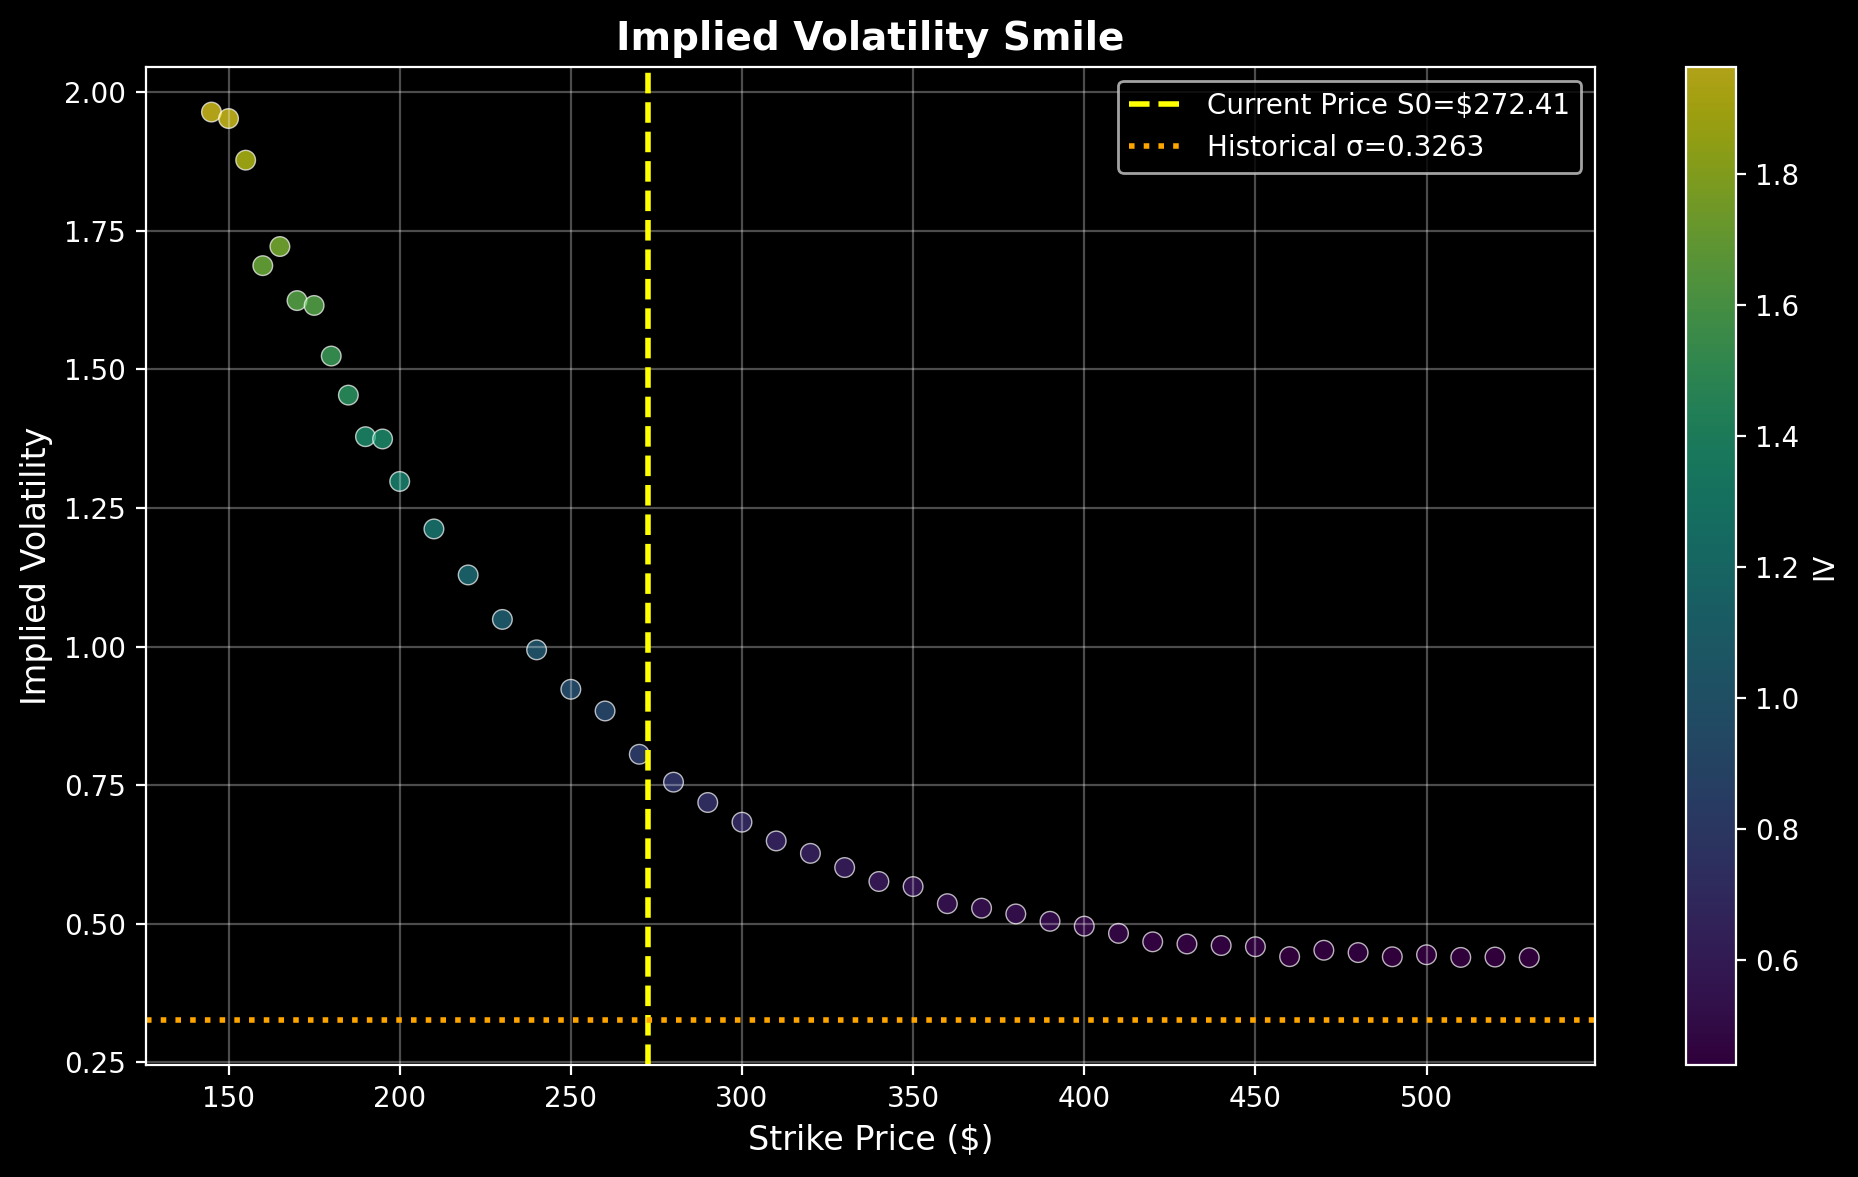

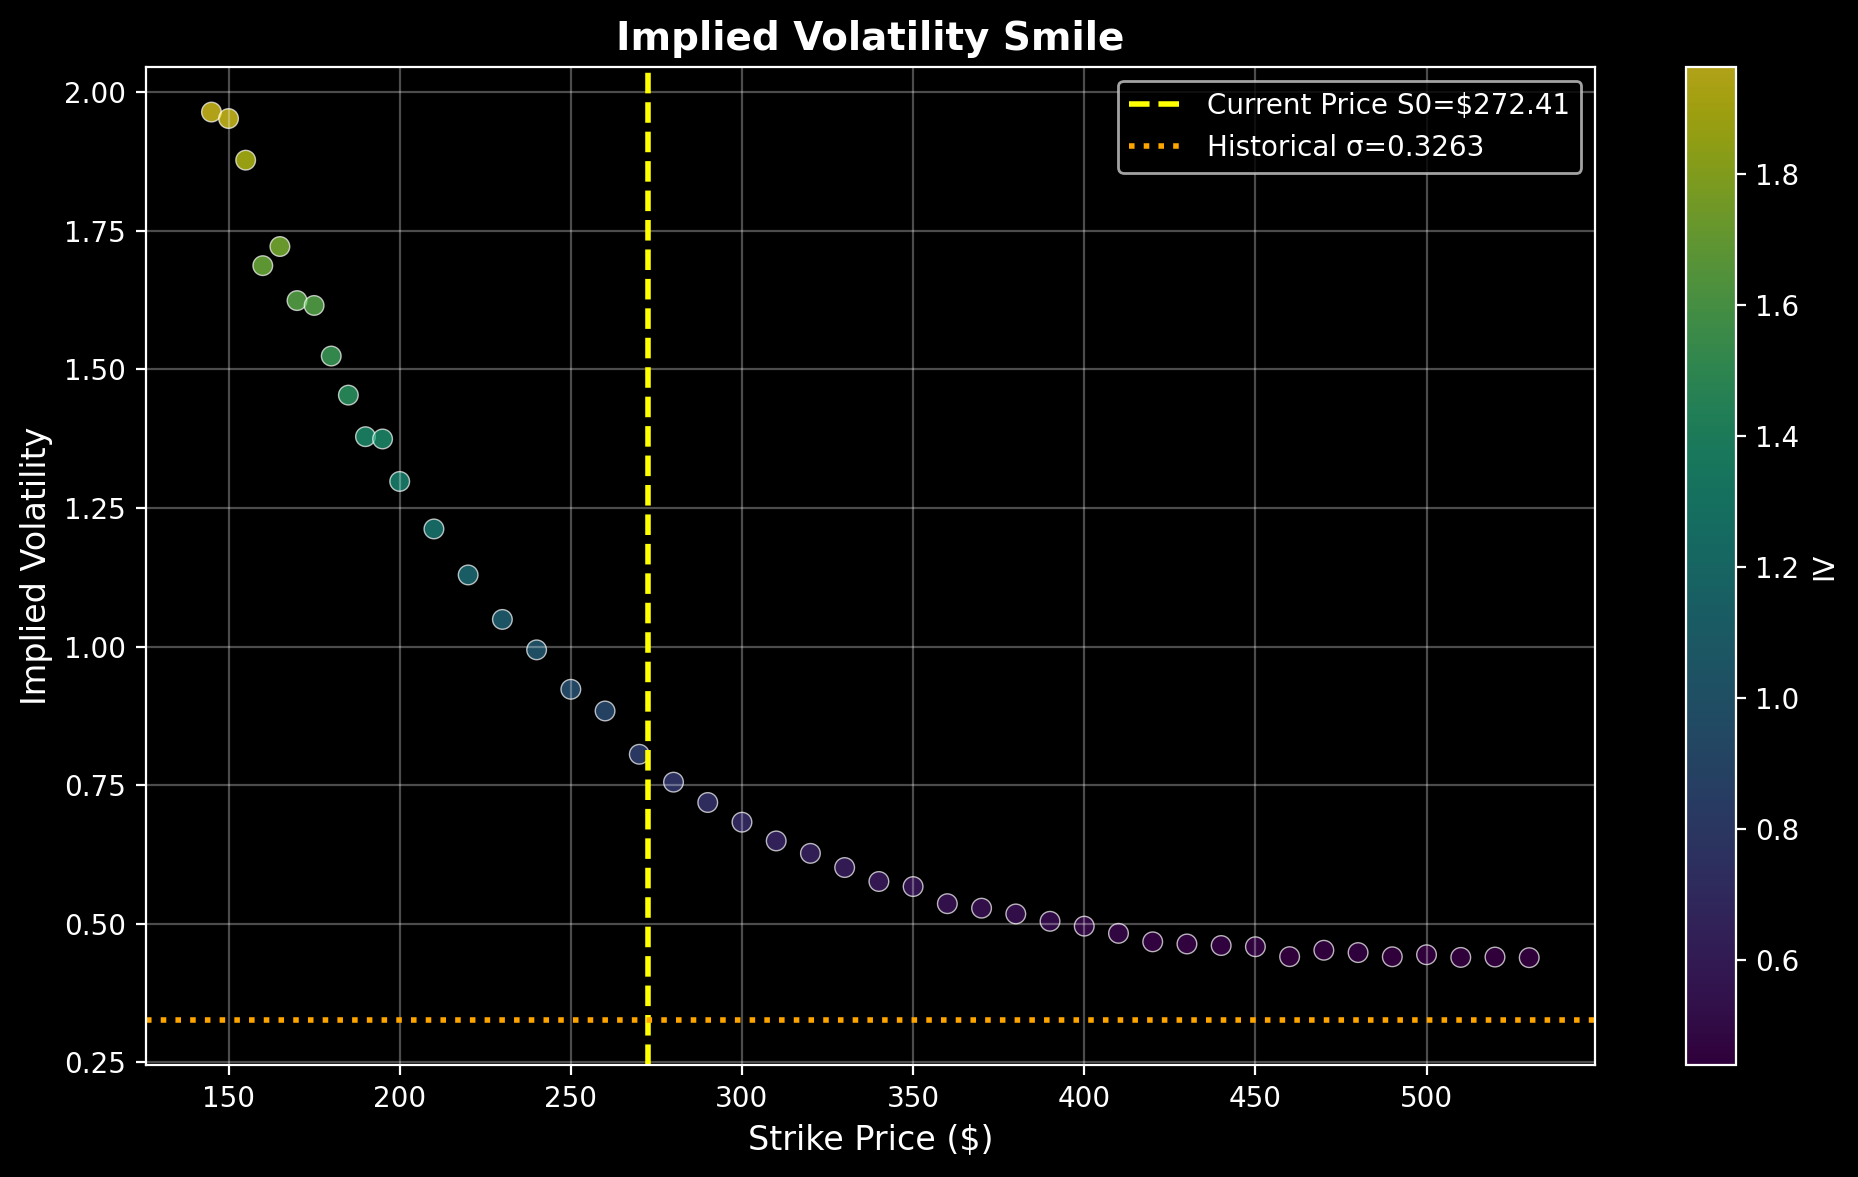

✅ IV Smile plot displayed


<Figure size 640x480 with 0 Axes>

In [ ]:
# Optional: Implied Volatility Smile Plot
if ivs is not None and len(ivs) > 0:
    fig_iv, ax_iv = plt.subplots(figsize=(10, 6))
    scatter = ax_iv.scatter(valid_strikes, ivs, c=ivs, cmap='viridis', s=50, alpha=0.7, 
                           edgecolors='white', linewidth=0.5)
    ax_iv.axvline(x=S0, color='yellow', linestyle='--', linewidth=2, 
                  label=f'Current Price S0=${S0:.2f}')
    ax_iv.axhline(y=sigma, color='orange', linestyle=':', linewidth=2, 
                  label=f'Historical σ={sigma:.4f}')
    ax_iv.set_xlabel('Strike Price ($)', fontsize=12)
    ax_iv.set_ylabel('Implied Volatility', fontsize=12)
    ax_iv.set_title('Implied Volatility Smile', fontsize=14, fontweight='bold')
    ax_iv.legend()
    ax_iv.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax_iv, label='IV')
    plt.tight_layout()
    plt.show(block=False)
    plt.draw()
    try:
        from IPython.display import display
        display(fig_iv)
    except:
        pass
    print("✅ IV Smile plot displayed")
else:
    print("No IV data available for smile plot")


## 8. Interactive GBM Paths Visualization (Optional)


In [ ]:
from ipywidgets import interact, FloatSlider

def plot_paths_interactive(sigma_slider):
    """Interactive plot with sigma slider."""
    paths_int = gbm_paths_div(S0, r, q, sigma_slider, T, steps, 100)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    time_axis = np.linspace(0, T, steps + 1)
    
    for i in range(100):
        ax.plot(time_axis, paths_int[:, i], alpha=0.3, linewidth=0.5)
    
    ax.axhline(y=K, color='r', linestyle='--', linewidth=2, label=f'Strike K=${K:.2f}')
    ax.axhline(y=S0, color='cyan', linestyle=':', linewidth=2, label=f'Initial S0=${S0:.2f}')
    ax.set_xlabel('Time (years)', fontsize=11)
    ax.set_ylabel('Stock Price ($)', fontsize=11)
    ax.set_title(f'Interactive GBM Paths (σ={sigma_slider:.4f}, q={q:.4f})', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show(block=False)
    plt.draw()
    try:
        from IPython.display import display
        display(fig)
    except:
        pass

# Create interactive widget
interact(plot_paths_interactive, 
         sigma_slider=FloatSlider(min=0.05, max=1.0, step=0.01, value=sigma, 
                                  description='Volatility (σ)', continuous_update=False))


## 9. Final Summary Statistics


In [ ]:
print("=" * 70)
print("MONTE CARLO PRICING SUMMARY")
print("=" * 70)
print(f"\nMarket Data:")
print(f"  Stock: AAPL")
print(f"  Current Price (S0): ${S0:.2f}")
print(f"  Strike (K): ${K:.2f}")
print(f"  Time to Expiration (T): {T:.2f} years")
print(f"  Risk-free Rate (r): {r:.4f} ({r*100:.2f}%)")
print(f"  Dividend Yield (q): {q:.4f} ({q*100:.2f}%)")
print(f"  Historical Volatility (σ): {sigma:.4f} ({sigma*100:.2f}%)")

print(f"\nOption Prices:")
print(f"  MC American Call: ${final_mc_price:.4f} ± ${1.96*final_mc_std:.4f} (95% CI)")
print(f"  BSM European Call: ${bsm_price:.4f}")
print(f"  Difference: ${abs(final_mc_price - bsm_price):.4f}")

if q == 0:
    print(f"\nNote: With q=0, American call ≈ European call (no early exercise benefit).")
else:
    print(f"\nNote: With q>0, early exercise may be optimal for American calls.")

if ivs is not None and len(ivs) > 0:
    print(f"\nImplied Volatility Statistics:")
    print(f"  Min IV: {ivs.min():.4f} ({ivs.min()*100:.2f}%)")
    print(f"  Max IV: {ivs.max():.4f} ({ivs.max()*100:.2f}%)")
    atm_idx = np.argmin(np.abs(valid_strikes - S0))
    print(f"  ATM IV (K≈${valid_strikes[atm_idx]:.2f}): {ivs[atm_idx]:.4f} ({ivs[atm_idx]*100:.2f}%)")
    print(f"  Mean IV: {ivs.mean():.4f} ({ivs.mean()*100:.2f}%)")
    print(f"  Historical σ: {sigma:.4f} ({sigma*100:.2f}%)")

print("\n" + "=" * 70)
